## Import Libraries

In [1]:
import os
import numpy as np
import shutil
import gc
import random

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler

import skimage.io as io

from tqdm import tqdm

import matplotlib.pyplot as plt

from PIL import Image

# Split Dataset

In [26]:
def create_text_file(data_dict, data_type, img_txt_path, mask_txt_path = None):
    """
    Function to create text files containing image paths and mask paths
    Args:
    data_dict: Dictionary containing image paths and mask paths
    data_type: "train" or "test" data
    img_text_path: Path of text file containing image paths.
    img_mask_path: Path of text file containing mask paths.

    Example:
    create_text_file(train_dict, "train", "train_images.txt", "train_masks.txt")
    """
    with open(img_txt_path, 'w') as f:
        with open(mask_txt_path, 'w') as i:
            for key, value in data_dict.items():
                f.write(value[0])
                i.write(value[1])

                f.write("\n")
                i.write("\n")
                
    print("\n\n{0} files created.\nImages: {1}\nMasks: {2}".format(data_type.capitalize(), img_txt_path, mask_txt_path))
    return

In [27]:
def split_data(data_dir, seed, split_ratio = [.80, .10, .10]):
    img_dir = os.path.join(data_dir, "images")
    mask_dir = os.path.join(data_dir, "masks")
    
    data_dict = {}
    for image in os.listdir(img_dir):
        img_path = os.path.join(img_dir, image)
        mask_path = os.path.join(mask_dir, image)
        data_dict[image] = [img_path, mask_path]

    # Random Seed
    random.seed(random_seed)
    data_list = list(data_dict.items())
    random.shuffle(data_list)
    
        
    # Data split
    train_size = int(len(data_list)*split_ratio[0])
    val_size = int(len(data_list)*split_ratio[1])
    test_size = len(data_list) - train_size - val_size

    train_dict = dict(data_list[:train_size])
    val_dict = dict(data_list[train_size:train_size+val_size])
    test_dict = dict(data_list[train_size+val_size:])
    
    return train_dict, val_dict, test_dict

In [28]:
data_dir = "data"
random_seed = 7
split_ratio = [.80, .10, .10]

train_dict, val_dict, test_dict = split_data(data_dir, random_seed, split_ratio)

train_img_txt = "data/train_images.txt"
train_mask_txt = "data/train_masks.txt"
val_img_txt = "data/val_images.txt"
val_mask_txt = "data/val_masks.txt"
test_img_txt = "data/test_images.txt"
test_mask_txt = "data/test_masks.txt"

create_text_file(train_dict, "train", train_img_txt, train_mask_txt)
create_text_file(val_dict, "val", val_img_txt, val_mask_txt)
create_text_file(test_dict, "test", test_img_txt, test_mask_txt)



Train files created.
Images: data/train_images.txt
Masks: data/train_masks.txt


Val files created.
Images: data/val_images.txt
Masks: data/val_masks.txt


Test files created.
Images: data/test_images.txt
Masks: data/test_masks.txt


## U-Net Parts

In [29]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## U-Net Model

In [30]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Dice BCE Loss

In [31]:
"""
Dice BCE Loss Borrowed from: https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch/notebook
"""

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)       
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

## Dataset Class

In [89]:
# Custom Dataset
class PolypDataset(Dataset):
    def __init__(self, data_file, label_file, input_size):
        with open(data_file) as f:
            self.image_paths = f.readlines()
        f.close()
        
        with open(label_file) as f:
            self.label_paths = f.readlines()
        f.close()

        self.image_paths = [x.strip() for x in self.image_paths]
        self.label_paths = [x.strip() for x in self.label_paths]
        
        self.input_size = input_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        label = io.imread(self.label_paths[idx])
        label = self.preprocess_label()(label)

        img = io.imread(self.image_paths[idx])
        img = self.preprocess()(img)
        return (img, label, idx)
    
    def preprocess(self):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.input_size, Image.BICUBIC),
            transforms.ToTensor(),
            ])
    
    def preprocess_label(self):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.input_size, Image.BICUBIC),
            transforms.Grayscale(num_output_channels = 1),
            transforms.ToTensor()
        ])

## Load Data

In [98]:
# Input size for model
input_size = (128, 128)

# Create train and validation sets
train_images_file = "data/train_images.txt"
train_labels_file = "data/train_masks.txt"
val_images_file = "data/val_images.txt"
val_labels_file = "data/val_masks.txt"

# Initialise Datasets
train_set = PolypDataset(train_images_file, train_labels_file, input_size)
val_set = PolypDataset(val_images_file, val_labels_file, input_size)

# Batch size for training
batch_size = 8

# Random seed for dataloader
random_seed = 7

# Initialize Dataloaders
torch.manual_seed(random_seed)
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = True)
print("Data Loaded.")

Data Loaded.


Model Input Shape:  torch.Size([8, 3, 128, 128])
Masks Shape:  torch.Size([8, 1, 128, 128])


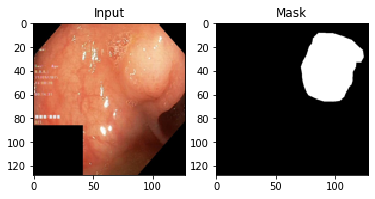

In [99]:
def get_image_sample(data_loader):
    # Get Sample
    inputs, masks, idx = next(iter(data_loader))
    
    # Display Masks
    fig, axes = plt.subplots(1, 2)
    titles = ['Input', 'Mask']
    image_sets = [inputs[0], masks[0]]
    for i, axis in enumerate(axes):
        if(i == 0):
            axis.imshow(image_sets[i].squeeze(0).permute(1, 2, 0))
        else:
            axis.imshow(image_sets[i].squeeze(0), cmap = 'gray')
        axis.set_title(titles[i])

    print("Model Input Shape: ", inputs.shape)
    print("Masks Shape: ", masks.shape)

# Get Sample
get_image_sample(train_loader)

## Train Model

In [100]:
def train(model, train_dataloader, val_dataloader, batch_size, num_epochs, learning_rate, patience, model_path, device):
    """
    Function to train a u-net model for segmentation.
    model: U-Net model
    Args:
        train_dataloader: training set
        val_dataloader: validation set
        batch_size: batch_size for training.
        num_epochs: number of epochs to train.
        learning_rate: learning rate for the optimiser
        patience: number of epochs for early stopping.
        model_path: checkpoint path to store the model.
        device: CPU or GPU to train the model.
    
    Returns: A dictionary containing the training and validation losses.
    """
    
    # Loss Collection
    train_losses  = []
    val_losses = []

    # Loss function
    criterion = DiceBCELoss().to(device)

    # Optimiser
    optimiser = optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min' if model.n_classes > 1 else 'max', patience=patience)

    # Patience count
    count = 0

    for epoch in tqdm(range(1, num_epochs+1)):
        current_train_loss = 0.0
        current_val_loss = 0.0

        # Train model
        model.train()
        for features, labels, idx in train_dataloader:
            optimiser.zero_grad()
            features, labels = features.to(device), labels.to(device)
            output = model.forward(features)
            loss = criterion(output, labels)
            loss.backward()
            optimiser.step()
            current_train_loss += loss.item()

            del features, labels
            gc.collect()
            torch.cuda.empty_cache()
            
        # Evaluate model
        model.eval()
        with torch.no_grad():
            for features, labels, idx in val_dataloader:
                features, labels = features.to(device), labels.to(device)
                output = model.forward(features)
                loss = criterion(output, labels)
                current_val_loss += loss.item()

                del features, labels
                gc.collect()
                torch.cuda.empty_cache()
        
        # Store Losses
        current_train_loss /= len(train_dataloader)
        train_losses.append(current_train_loss)

        current_val_loss /= len(val_dataloader)
        val_losses.append(current_val_loss)

        print("Epoch: {0:d} -> Train Loss: {1:0.8f} Val Loss: {2:0.8f} ".format(epoch, current_train_loss, current_val_loss))
        if((epoch == 1) or (current_val_loss < best_val_loss)):
            best_val_loss = current_val_loss
            eq_train_loss = current_train_loss
            best_epoch = epoch
            count = 0

            # Save best model
            torch.save(model.state_dict(), model_path)
        
        # Check for patience level
        if(current_val_loss > best_val_loss):
            count += 1
            if(count == patience):
                break

    # Save best parameters
    best_model_params = {'train_losses': train_losses, 
                        'val_losses': val_losses, 
                        'best_val_loss': best_val_loss,
                        'eq_train_loss': eq_train_loss,
                        'best_epoch': best_epoch}
                             
    return best_model_params

In [107]:
# Checkpoint path
output_dir = "experiment_test"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

save_path = os.path.join(output_dir, "polyp_unet.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initiliase Model
torch.manual_seed(random_seed)
model = UNet(n_channels = 3, n_classes = 1, bilinear = False).to(device)

# Hyperparameters
num_epochs = 10
learning_rate = 0.0001
patience = 10

# Train model
best_model_params = train(model, train_loader, val_loader, batch_size, num_epochs, 
                          learning_rate, patience, save_path, device)


 10%|████████▎                                                                          | 1/10 [00:31<04:42, 31.34s/it]

Epoch: 1 -> Train Loss: 1.50605520 Val Loss: 1.49164899 



 20%|████████████████▌                                                                  | 2/10 [01:02<04:10, 31.33s/it]

Epoch: 2 -> Train Loss: 1.46901990 Val Loss: 1.47728251 



 30%|████████████████████████▉                                                          | 3/10 [01:34<03:40, 31.52s/it]

Epoch: 3 -> Train Loss: 1.44050919 Val Loss: 1.43588905 
Epoch: 4 -> Train Loss: 1.41779650 Val Loss: 1.40777164 



 50%|█████████████████████████████████████████▌                                         | 5/10 [02:39<02:39, 31.92s/it]

Epoch: 5 -> Train Loss: 1.39976434 Val Loss: 1.38812684 
Epoch: 6 -> Train Loss: 1.38009238 Val Loss: 1.37509000 



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:11<02:08, 32.00s/it]


Epoch: 7 -> Train Loss: 1.36631250 Val Loss: 1.35431997 


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:16<01:04, 32.20s/it]

Epoch: 8 -> Train Loss: 1.35082078 Val Loss: 1.35007802 



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:48<00:32, 32.15s/it]

Epoch: 9 -> Train Loss: 1.33817294 Val Loss: 1.33214451 



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:20<00:00, 32.08s/it]

Epoch: 10 -> Train Loss: 1.32567327 Val Loss: 1.32927270 


In [108]:
print("Training complete.")

# Delete model to free memory
del model, best_model_params
gc.collect()
torch.cuda.empty_cache()

Training complete.


In [109]:
# Get test set
test_images_file = "data/test_images.txt"
test_labels_file = "data/test_masks.txt"

input_size = (128, 128)
torch.manual_seed(7)
test_set = PolypDataset(test_images_file, test_labels_file, input_size)
test_loader = DataLoader(test_set, batch_size = 1, sampler = RandomSampler(test_set))

# Inference device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Model
model_path = "experiment_test/polyp_unet.pth"
model = UNet(n_channels = 3, n_classes = 1, bilinear = False).to(device)
model.load_state_dict(torch.load(model_path, map_location = device))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [110]:
# Predict Function
def predict_mask(input, threshold):
    output = model(input.to(device))
    output = torch.sigmoid(output).detach().cpu().numpy()
    pred = output > threshold

    return pred

# Threshold for prediction
threshold = 0.5

# Get test image
input, label, idx = next(iter(test_loader))

pred = predict_mask(input, threshold)

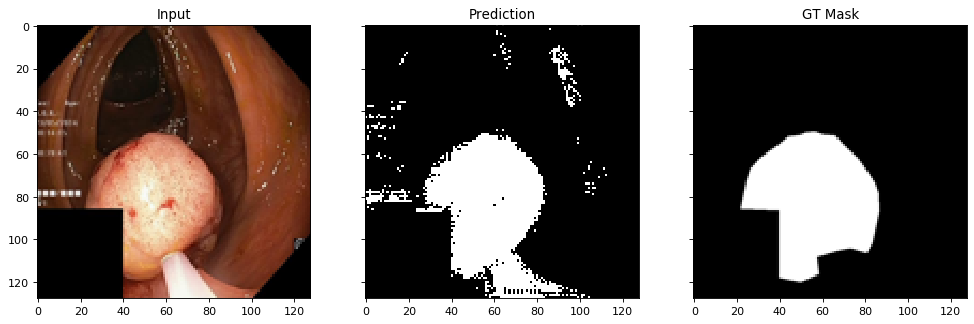

In [111]:
def visualize(input, pred):
    fig, axes = plt.subplots(1, 3, figsize=(15, 7), dpi=80, sharex=True, sharey=True)
    titles = ['Input', 'Prediction', 'GT Mask']
    image_sets = [input, pred, label]
    for i, axis in enumerate(axes):
        if (i == 0):
            img = image_sets[i].squeeze(0).permute(1, 2, 0)
        else:
            img = image_sets[i].squeeze()
        axis.imshow(img, cmap = 'gray')
        axis.set_title(titles[i])


# Visualise Prediction
visualize(input, pred)